In [133]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.tri as tri
import datetime 
import time
#import netcdftime
import sys
import glob
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import os
from scipy.interpolate import griddata
import csv
#from mpl_toolkits.basemap import Basemap
from scipy import interpolate
import xarray as xr
import seaborn as sns

In [42]:
def get_data(len_data, NU_WU):  #len_data is the number of files i want to read in (e.g. 4 for 4h hourly data), NU_WU is a str and you can define if you want 'with urban' or 'no urban'
    ds_data = {}  
    for i in range(1, len_data + 1):
        filename = f'../det_data_all_2022/fc_DOM01_0{i:03d}_{NU_WU}_urban_grid.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
 #           print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')
    
    return ds_data

This script is adapted from Arianna Valmassoi, credits go to her.

In [11]:
#define a color map for the plot later

colors_orig = [ (103,0,31),(178,24,43),(214,96,77),(244,165,130),(253,219,199),(255,255,255),(209,229,240),(146,197,222),(67,147,195),(33,102,172),(5,48,97)]
colorsm=[[a/255. for a in x] for x in colors_orig]
div_color= LinearSegmentedColormap.from_list( 'div_color', colorsm, N=49)
level=np.arange(-5,5,.2) #-.6,.5,.05)  #
bounds=level.tolist()
cmap = div_color
cmaplist = [cmap(i) for i in range(cmap.N,0,-1)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [43]:
# #open dataset with temperature variable

# datafile = xr.open_dataset('/data/hubhome/s6mabohm/Masterarbeit/fc_DOM01_0002_URB_temp_grid.nc') 
# #datafile = datafile.isel(height=slice(60))
# a = datafile.variables['U'][0,:,:]

In [44]:
data_WU_det = get_data(120, 'WU')
data_NU_det = get_data(120, 'NU')

In [69]:
a = data_WU_det[25].variables['U'][0,:,:]

In [29]:
#open external paramters for topography and urban land use information

cor = xr.open_dataset('/data/hubhome/s6mabohm/Masterarbeit/extpar_icon_grid_0026_R03B07_G.nc')
luf = cor.variables['LU_CLASS_FRACTION'][:,:]
topo = cor.variables['topography_c'][:]

In [76]:
clons  = np.rad2deg(data_WU_det[25]["clon"])
clats  = np.rad2deg(data_WU_det[25]["clat"])

In [77]:
#open height level file

hhl_file = xr.open_dataset("/data/hubhome/s6mabohm/Masterarbeit/hhl.nc")
hhl = hhl_file.variables["HHL"][0,:,:]#[::-1]
hhl_f = hhl
### Full levels: because the levels are defined at half levels, it is corrected here
for k in range(1,hhl.shape[0]):
    hhl_f[k,:] = hhl[k,:] + (hhl[k,:]-hhl[k-1,:])/2


/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects ins

In [78]:
#extract index of the geographic regions where we want to do the interpolation

lar1 = 51.5
lar2 = 53.5
lor1 = 12
lor2 = 14


ind=[]
for i in range(0,clons.shape[0]):
    if ((clats[i]<lar2 and clats[i]>lar1) and (clons[i]>lor1 and clons[i]<lor2)): #find the indexes and select the values after
        ind.append(i)

In [35]:
#ind_berlin = np.save('ind_berlin_crossection.npy', ind)

#ind = np.load('ind_berlin_crossection.npy')



In [51]:
#save it for Berlin to save some computational time when doing it again

#np.save('ind_array_berlin.npy', ind)
#ind = np.load('/data/hubhome/s6mabohm/Masterarbeit/ind_array_berlin.npy')

In [96]:
#defining the lon lat values for the cross section, where the interpolation is suppose to be mapped

lo_i = 12.1
la_i = 52.51
lo_f = 13.9
la_f = 52.53

lo_line = np.linspace(lo_i,lo_f,60)
la_line = np.linspace(la_i,la_f,60)
cross_line = np.vstack(( np.linspace(lo_i,lo_f,60), np.linspace(la_i,la_f,60) )).T
interp_method = 'cubic'
c = []
### Cross line as tuples
for i in range(1,cross_line.shape[0]+1):
    c.append(i)
lons=clons[ind]
lats=clats[ind]
lons=lons
i_c=np.vstack((lons,lats)).T

In [81]:
#initializing arrays

cross_val=np.zeros((hhl_f.shape[0]-1,len(cross_line)))
cross_fl =np.zeros((hhl_f.shape[0]-1,len(cross_line)))
cross_test =np.zeros((hhl_f.shape[0]-1,len(cross_line)))

In [92]:
# horizontal interpolation
for i in range(a.shape[0]-1,0,-1):
    hhlf_i = griddata(i_c,hhl_f[i,ind],cross_line,method=interp_method)
#    print(i, hhlf_i)
    test = griddata(i_c,a[i,ind],cross_line,method=interp_method)
#    print(i,test)
    val = test
#    print(val)
    cross_val[i,:] = val
    cross_fl[i,:] = hhlf_i
    cross_test[i,:] = c

QhullError: QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull d Qbb Qz Qc Qt Q12
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 918172727  delaunay  Qbbound-last  Qz-infinity-point  Qcoplanar-keep
  Qtriangulate  Q12-allow-wide  _pre-merge  _zero-centrum  Qinterior-keep
  _maxoutside  0


In [685]:
#creating x-labels for the plot

x_labels = []
cross_line_lab = np.vstack([np.linspace(lo_i, lo_f, 60), np.linspace(la_i, la_f, 60)]).T
x_labels = [[round(pair[0], 2), round(pair[1], 2)] for pair in cross_line_lab]
print(x_labels)

[[12.1, 52.51], [12.13, 52.51], [12.16, 52.51], [12.19, 52.51], [12.22, 52.51], [12.25, 52.51], [12.28, 52.51], [12.31, 52.51], [12.34, 52.51], [12.37, 52.51], [12.41, 52.51], [12.44, 52.51], [12.47, 52.51], [12.5, 52.51], [12.53, 52.51], [12.56, 52.52], [12.59, 52.52], [12.62, 52.52], [12.65, 52.52], [12.68, 52.52], [12.71, 52.52], [12.74, 52.52], [12.77, 52.52], [12.8, 52.52], [12.83, 52.52], [12.86, 52.52], [12.89, 52.52], [12.92, 52.52], [12.95, 52.52], [12.98, 52.52], [13.02, 52.52], [13.05, 52.52], [13.08, 52.52], [13.11, 52.52], [13.14, 52.52], [13.17, 52.52], [13.2, 52.52], [13.23, 52.52], [13.26, 52.52], [13.29, 52.52], [13.32, 52.52], [13.35, 52.52], [13.38, 52.52], [13.41, 52.52], [13.44, 52.52], [13.47, 52.53], [13.5, 52.53], [13.53, 52.53], [13.56, 52.53], [13.59, 52.53], [13.63, 52.53], [13.66, 52.53], [13.69, 52.53], [13.72, 52.53], [13.75, 52.53], [13.78, 52.53], [13.81, 52.53], [13.84, 52.53], [13.87, 52.53], [13.9, 52.53]]


In [5]:
#define a color map for the plot later

colors_orig = [ (103,0,31),(178,24,43),(214,96,77),(244,165,130),(253,219,199),(255,255,255),(209,229,240),(146,197,222),(67,147,195),(33,102,172),(5,48,97)]
colorsm=[[a/255. for a in x] for x in colors_orig]
div_color= LinearSegmentedColormap.from_list( 'div_color', colorsm, N=49)
level=np.arange(-5,5,.2) #-.6,.5,.05)  #
bounds=level.tolist()
cmap = div_color
cmaplist = [cmap(i) for i in range(cmap.N,0,-1)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)



In [4]:
colors_orig = [(103, 0, 31), (178, 24, 43), (214, 96, 77), (244, 165, 130), (253, 219, 199),
               (255, 255, 255), (209, 229, 240), (146, 197, 222), (67, 147, 195), (33, 102, 172), (5, 48, 97)]

colorsm = [(r / 255., g / 255., b / 255.) for (r, g, b) in reversed(colors_orig)]
cmap = mpl_colors.LinearSegmentedColormap.from_list('Custom cmap', colorsm, N=256)
levels = np.arange(-4, 4, 0.2)
bounds = levels.tolist()
norm = mpl_colors.BoundaryNorm(bounds, cmap.N)



params = {'axes.labelsize': 30,'axes.titlesize':30, 'legend.fontsize': 30, 'xtick.labelsize': 30, 
          'ytick.labelsize': 30}
plt.rcParams.update(params)

vmin = -3
vmax = 3

fig, ax =plt.subplots( figsize=(20, 20))
CS = plt.contourf(cross_test,cross_fl, cross_val,20, cmap=cmap)

## interp of invar fields:
topo_i = griddata(i_c,topo[ind],cross_line,method=interp_method)
lu_i = griddata(i_c,luf[18,ind],cross_line,method=interp_method)

plt.fill_between(c,-5,topo_i,color='k')

lu_urb = lu_i

for i in range(0,lu_i.shape[0]):
  if (lu_urb[i]<.6):
      lu_urb[i]= np.nan
  else:
      lu_urb[i]=20

plt.fill_between(c,20,lu_urb,color='r')

plt.ylim(0,2000)
plt.ylabel('Height [m]')
plt.xlabel('Lat, Lon')
plt.xlim(5,60)
plt.xticks(c[5::5],x_labels[5::5],rotation=30)
cbar = plt.colorbar(CS)
cbar.set_label('$T - \overline{T}$ [K]')
plt.show()

NameError: name 'mpl_colors' is not defined

In [134]:
sns.set_style("whitegrid")

In [135]:
height = []

for i in range(120):
    b = hhl_f[i, 74].values
    height.append(b)

height = np.stack(height)
#print(height)
len(height)

120

In [138]:
data_WU_det[25].U

<xarray.DataArray 'U' (time: 1, height: 120, cell: 247)>
[29640 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2022-06-16
    clon     (cell) float64 0.6574 0.656 0.6559 0.6572 ... -1.232 0.325 0.323
    clat     (cell) float64 0.9736 0.9751 0.9721 ... -0.5839 -0.5921 -0.5926
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 117.0 118.0 119.0 120.0
Dimensions without coordinates: cell
Attributes:
    standard_name:  eastward_wind
    long_name:      U-Component of Wind
    units:          m s-1
    param:          2.2.0
    CDI_grid_type:  unstructured

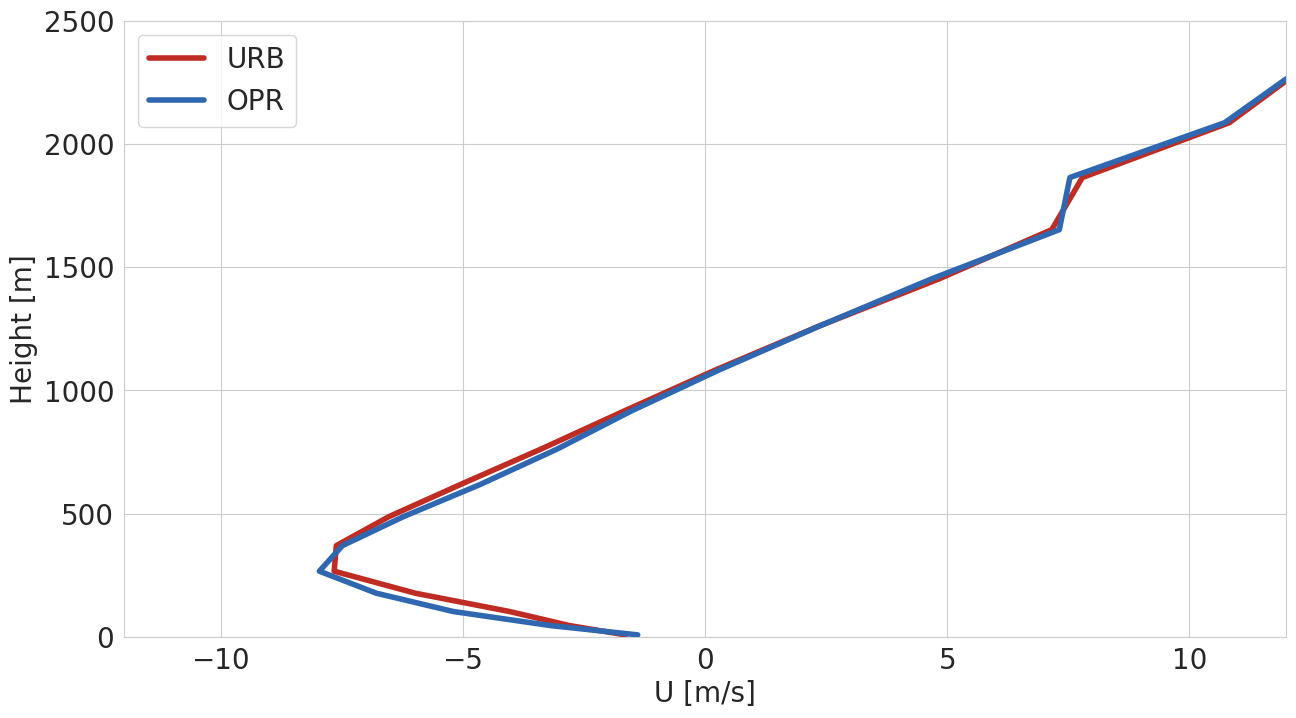

In [163]:
params = {'axes.labelsize': 20,
          'axes.titlesize': 20,
          'legend.fontsize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20}
plt.rcParams.update(params)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(data_WU_det[25].U.isel(cell=74).values[0], height, label='URB', color='#BF2C23', lw = 4)
ax.plot(data_NU_det[25].U.isel(cell=74).values[0], height, label='OPR', color='#2F67B1', lw = 4)
ax.grid(True)

ax.set_ylim(0, 2500)
ax.set_xlim(-12, 12)

# Set labels and title
ax.set_xlabel('U [m/s]')
ax.set_ylabel('Height [m]')
plt.legend()

plt.savefig('../plots_2024/wind_berlin_160622_0000.jpeg', bbox_inches ='tight')
